In [1]:
import os
import sys
import random
import math
import re
import time
import colorsys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import IPython.display
import matplotlib.image as mpimg
ROOT_DIR = os.path.abspath("/")
sys.path.append(ROOT_DIR)
from mrcnn import utils
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist
from mrcnn import visualize
from mrcnn.visualize import display_images
import imutils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import json
import imutils
import cv2
import skimage
%matplotlib inline
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
WEIGHTS_PATH = r"D:\Fiver\bijubrisi\model\bread segmentaion\mask_rcnn_object_0030.h5"

%config Completer.use_jedi = False

Using TensorFlow backend.


In [2]:
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    NAME = "object"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 25
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        
        self.add_class("object", 1, "bread")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open(os.path.join(dataset_dir, "vgg_json.json")))
        # print(annotations1)
        annotations = list(annotations1.values()) 
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"bread": 1} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
config = CustomConfig()
DEVICE = "/gpu:0" 
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

CUSTOM_DIR = r"D:\Fiver\bijubrisi\model\bread segmentaion"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [6]:
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [7]:
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\Fiver\bijubrisi\model\bread segmentaion\mask_rcnn_object_0030.h5








1
Processing 1 images
image                    shape: (532, 800, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


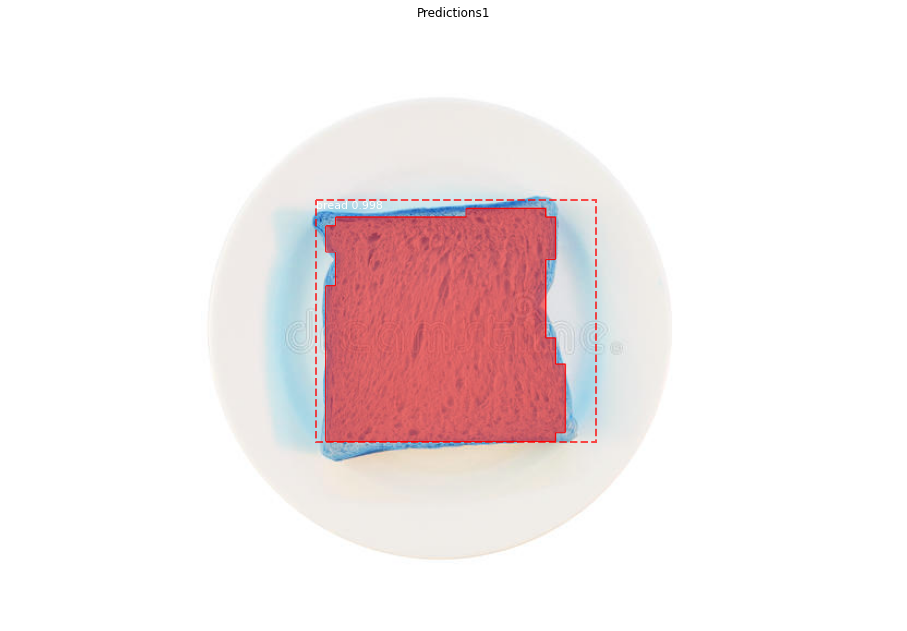

In [8]:
path_to_new_image = r"D:\Fiver\bijubrisi\model\bread segmentaion\test\2.jpg"
image1 = cv2.imread(path_to_new_image)
# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

In [9]:
def apply_mask_bw(image, mask):
    """Apply the given mask to the image.
    """
    black = image
    black[black > 0] = 0
    black[:, :] = np.where(mask == 1, 255, black[:, :])
    return black

In [10]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
            

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

objects: ['bread', 'bread']
numids [1, 1]
objects: ['bread']
numids [1]
objects: ['bread', 'bread']
numids [1, 1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread', 'bread']
numids [1, 1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
objects: ['bread']
numids [1]
Images: 15
Classes: ['BG', 'bread']
Processing 1 images
image                    shape: (1199, 1783, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1783.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


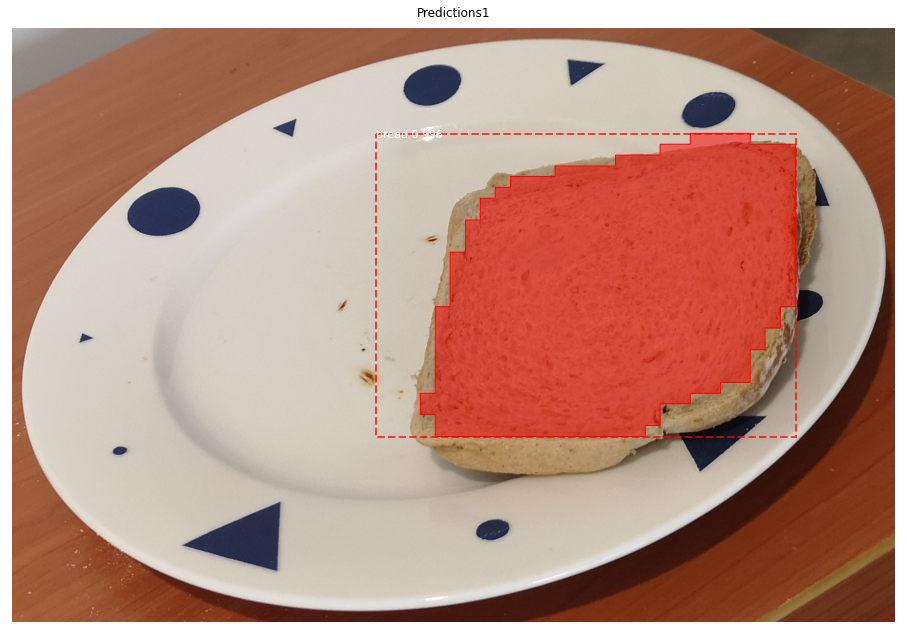

In [11]:
def cv2show(img):
    img = cv2.resize(img, (500,500))
    cv2.imshow("win", img)
    cv2.waitKey(0)

config = CustomConfig()
DEVICE = "/gpu:0" 
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

CUSTOM_DIR = r"D:\Fiver\bijubrisi\model\bread segmentaion"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

path_to_new_image = r"D:\Fiver\bijubrisi\model\bread segmentaion\test\2 slices bread - side.jpg"
image1 = cv2.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
r1 = results1[0]




masked_image = image1.astype(np.uint8).copy()
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
b = masked_image.copy()
b[b>0] = 0
N = r1['rois'].shape[0]
for i in range(N):
    mask = r1['masks'][:, :, i]
    masked_image = apply_mask_bw(masked_image, mask)
    b = b + masked_image
    
    
r1 = results1[0]
ax = get_ax(1)
display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

In [12]:
cv2show(b)

In [13]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

image1 = cv2.imread(path_to_new_image)
img_contour = image1
l = np.array([65, 38, 35])
h = np.array([95, 65, 55])
mask = cv2.inRange(img_contour, l, h)
# mask = cv2.Canny(mask, 200, 100)
# mask = cv2.dilate(mask, none, iterations=1)

cnts, h = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# cnts = imutils.grab_contours(cnts)
# (cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None
orig = None
orig = image1.copy()
for c in cnts:
    area = cv2.contourArea(c)
    if area == 10366.5:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        obj_corners = len(approx)
        print(area, obj_corners)
        
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box, dtype=int)
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0,0,255),2)
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 7, (0, 255,0 ), -1)
            
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        
        (trbrX, trbrY) = midpoint(tr, br)
        (tlblX, tlblY) = midpoint(tl, bl)
        
        
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (0, 255, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (0, 255, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (0, 255, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (0, 255, 0), -1)
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 2)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 2)
        
        pixel_w = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        pixel_h = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        
        area_px_ref = pixel_w * pixel_h
        pixel_per_metric = area_px_ref / 707

# contours, hierchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# for cnt in contours:
#     area = cv2.contourArea(cnt)
#     if(area > 1300):
#         cv2.drawContours(img_contour, cnt, -1, (0,255,0), 5)
        
#         peri = cv2.arcLength(cnt, True)
#         approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
#         obj_corners = len(approx)
#         print(area, obj_corners)
#         x, y, w, h = cv2.boundingRect(approx)
# #         cv2.rectangle(img_contour, (x,y), (x+w, y+h), (0,0,255), 6)
cv2show(orig)

10366.5 8


In [14]:
kernel = np.ones((5,5), np.uint8)
canny = cv2.Canny(b, 200, 100)
dil = cv2.dilate(canny, kernel, iterations=15)
cv2show(dil)
image1 = cv2.imread(path_to_new_image)
img_contour = image1
contours, hierchy = cv2.findContours(dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(area)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
    box = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    x, y, w, h = cv2.boundingRect(approx)
    box = perspective.order_points(box)
    cv2.drawContours(img_contour, [box.astype("int")], -1, (0, 255, 0), 2)
    (tl, tr, br, bl) = box
    pixel_w_object = dist.euclidean(tl, tr)
    pixel_h_object = dist.euclidean(tl, bl)
    actual_area = (pixel_w_object*pixel_h_object) / pixel_per_metric
    print(int(actual_area))
#     cv2.rectangle(img_contour, (x,y), (x+w, y+h), (0,0,255), 6)
    cv2.putText(img_contour, "area = {}mm".format(int(actual_area)), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 5)
    
cv2show(img_contour)   

441833.0
28783
